In [ ]:
!pip install missingno

In [62]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import re


import random
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha
import seaborn as sns
import missingno as msno
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

In [63]:
l=list(string.ascii_uppercase)
b=np.array(l+[x+y for x in l for y in l])
b = b[:123]

In [64]:
data = pd.read_csv('MI.data', usecols = list(range(1,124)), names=b,header=None)

In [65]:
data.head()

,A,B,C,D,E,F,G,H,I,J,...,DJ,DK,DL,DM,DN,DO,DP,DQ,DR,DS
0,77,1,2,1,1,2,?,3,0,7,...,0,0,0,0,0,0,0,0,0,0
1,55,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,52,1,0,0,0,2,?,2,0,2,...,0,0,0,0,0,0,0,0,0,0
3,68,0,0,0,0,2,?,2,0,3,...,0,0,0,0,0,0,1,0,0,0
4,60,1,0,0,0,2,?,3,0,7,...,0,0,0,0,0,0,0,0,0,0


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Columns: 123 entries, A to DS
dtypes: int64(13), object(110)
memory usage: 1.6+ MB


In [67]:
data = data.replace('?',np.nan)

In [68]:
for column in data.columns:
    data[column] = data[column].astype(float)

In [69]:
data.head()

,A,B,C,D,E,F,G,H,I,J,...,DJ,DK,DL,DM,DN,DO,DP,DQ,DR,DS
0,77.0,1.0,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.0,1.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,60.0,1.0,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# for column in data.columns:
#     plt.hist(data[column])
#     plt.show()

In [71]:
abbs = []
descriptions = []
types = []
counter = 1
with open('attributes.txt', 'r', encoding='utf8') as f:
    for line in f:
        split_line = line.split('.')
        num = split_line[0]
        try:
            num = int(num)
            if num == counter:
                counter += 1
                
                # Add description of attribute to list
                descriptions += [split_line[1]]
                
                # Add abbreviations of attributes to list
                abb_candidates = re.findall('\(.*?\)',line)
                if len(abb_candidates) == 1:
                    abbs += [abb_candidates[0][1:-1]]
                else:
                    abbs += [re.sub('[()]', '', a) for a in abb_candidates if '_' in a]
                    
                # Add data type to list
                if 'Nominal' in line:
                    types += ['Nominal']
                elif 'Ordinal' in line:
                    types += ['Ordinal']
                elif 'Real' in line:
                    types += ['Real']
                else:
                    print(line)
        except:
            pass
        
f.close()

abbs = np.array(abbs)
descriptions = np.array(descriptions)
types = np.array(types)

1. Record ID (ID): Unique identifier. Cannot be related to participant. It can be used for reference only.



In [72]:
data.columns = abbs[1:]

In [73]:
data['DECEASED'] = data.LET_IS.apply(lambda x: x if x == 0 else 1)
abbs = np.append(abbs, 'DECEASED')
descriptions = np.append(descriptions, 'Whether or not patient is deceased')
types = np.append(types,'Nominal')

In [74]:
data.head()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS,DECEASED
0,77.0,1.0,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.0,1.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60.0,1.0,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
data.shape

(1700, 124)

In [76]:
from sklearn.model_selection import train_test_split
df_train, df_validation  = train_test_split(data, test_size=0.2, random_state=42)
y_validation = df_validation['DECEASED']
non_deceased = np.sum(df_train['DECEASED'] == 0) 
balanced_df = pd.concat([df_train.query('DECEASED == False'), df_train.query('DECEASED == True').sample(non_deceased, random_state=42, replace=True)])
balanced_df

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS,DECEASED
1376,51.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1323,71.0,0.0,0.0,NaN,NaN,2.0,NaN,2.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1179,80.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
651,74.0,0.0,0.0,3.0,3.0,1.0,NaN,2.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,65.0,0.0,0.0,5.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,75.0,0.0,1.0,5.0,2.0,1.0,NaN,3.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0
1656,64.0,1.0,3.0,6.0,3.0,1.0,NaN,2.0,0.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0
1548,65.0,1.0,2.0,6.0,2.0,NaN,NaN,3.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0
1587,65.0,0.0,2.0,NaN,NaN,1.0,NaN,2.0,0.0,7.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0


In [77]:
attributes = dict(zip(abbs, descriptions))

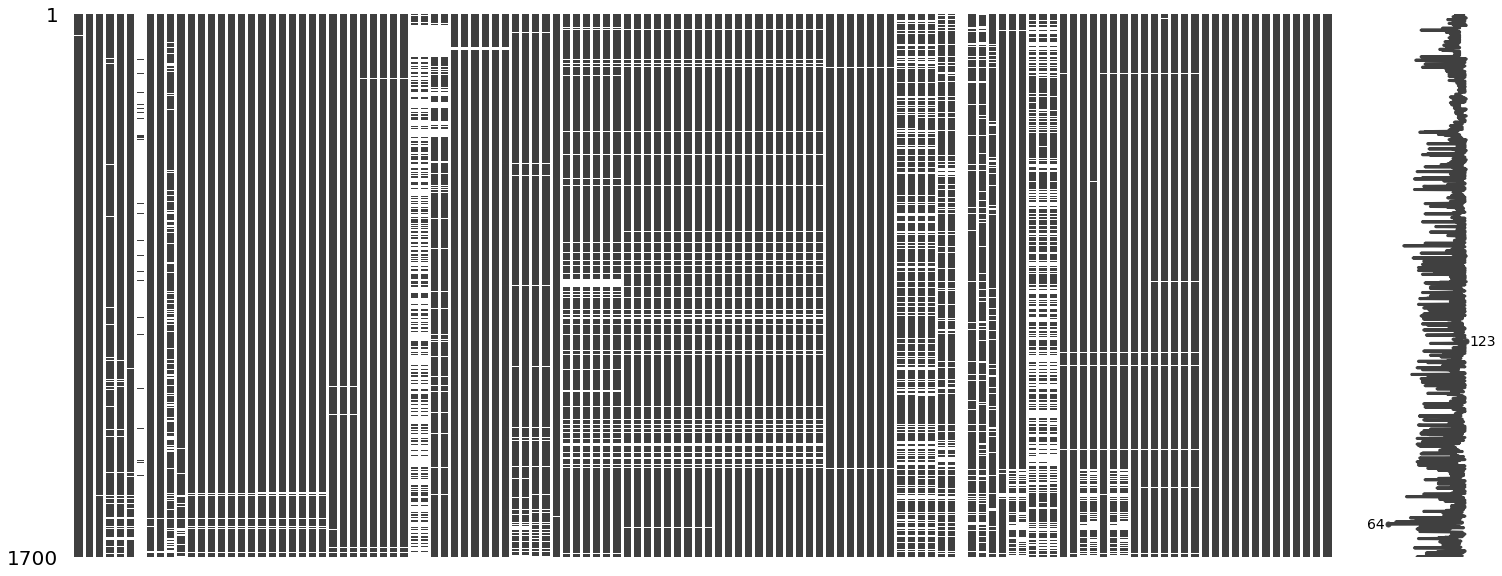

In [78]:
msno.matrix(data)
plt.show()

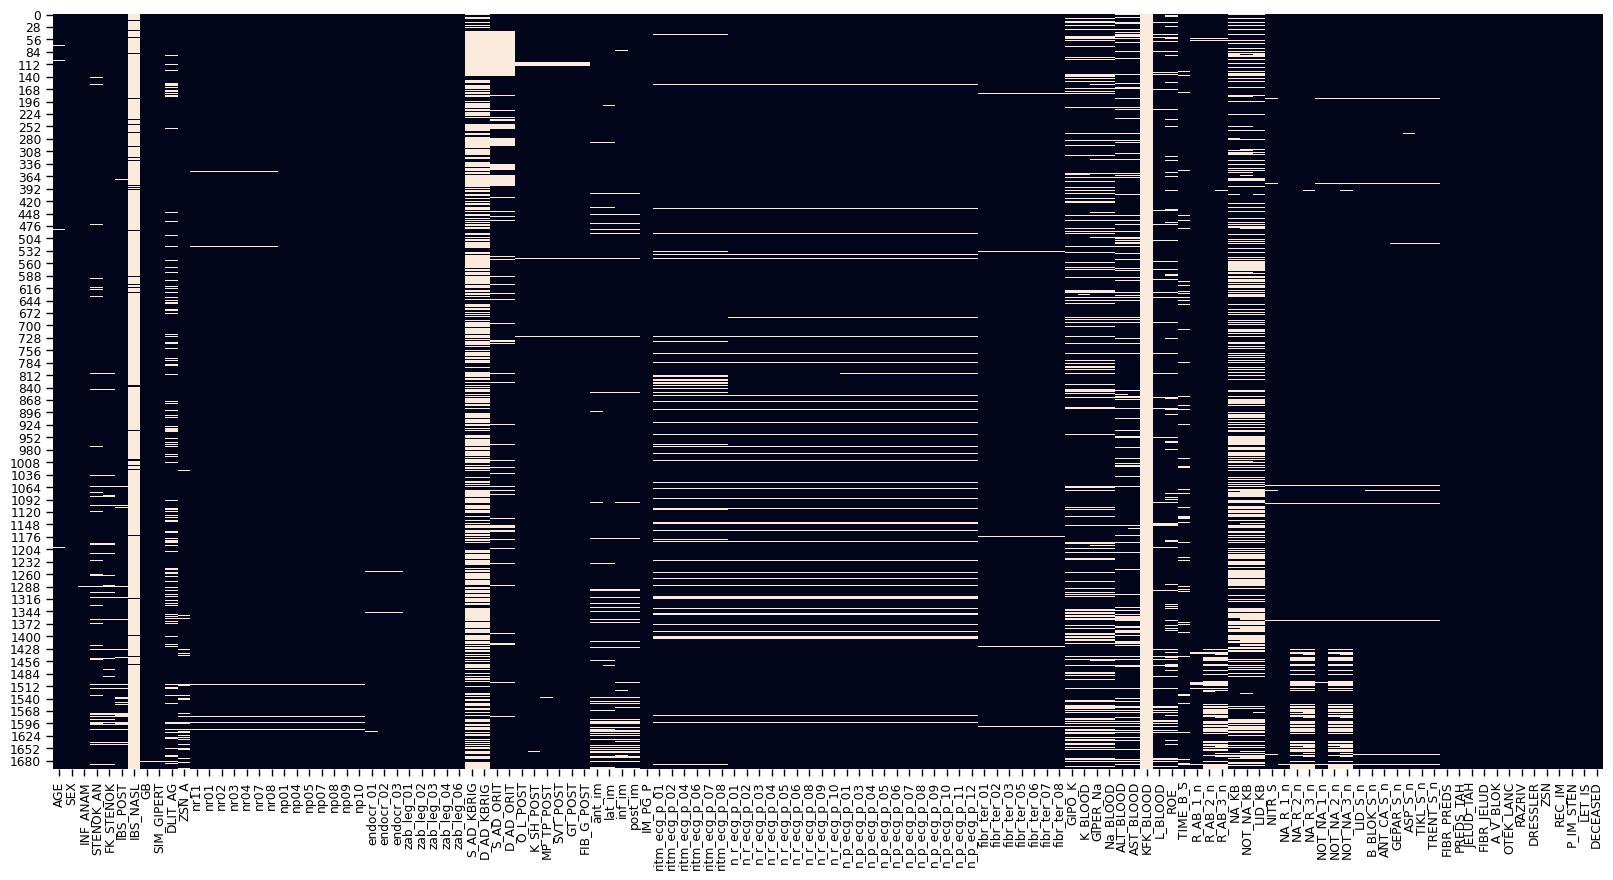

In [79]:
sns.set_context('paper')
plt.figure(figsize = (20,10), dpi = 100)
sns.heatmap(data.isnull(), cbar=False);
sns.set_context('poster')

In [80]:
X_total = data[data.columns[:111]]
X_balanced = balanced_df[balanced_df.columns[:111]]
X_validation = df_validation[df_validation.columns[:111]]

types = types[:111]

X_total = X_total.drop(abbs[np.array([93, 94, 95, 100, 101, 102, 103, 104, 105]) - 2], axis=1)
X_balanced = X_balanced.drop(abbs[np.array([93, 94, 95, 100, 101, 102, 103, 104, 105]) - 2], axis=1)
X_validation = X_validation.drop(abbs[np.array([93, 94, 95, 100, 101, 102, 103, 104, 105]) - 2], axis=1)

X_total.shape

(1700, 102)

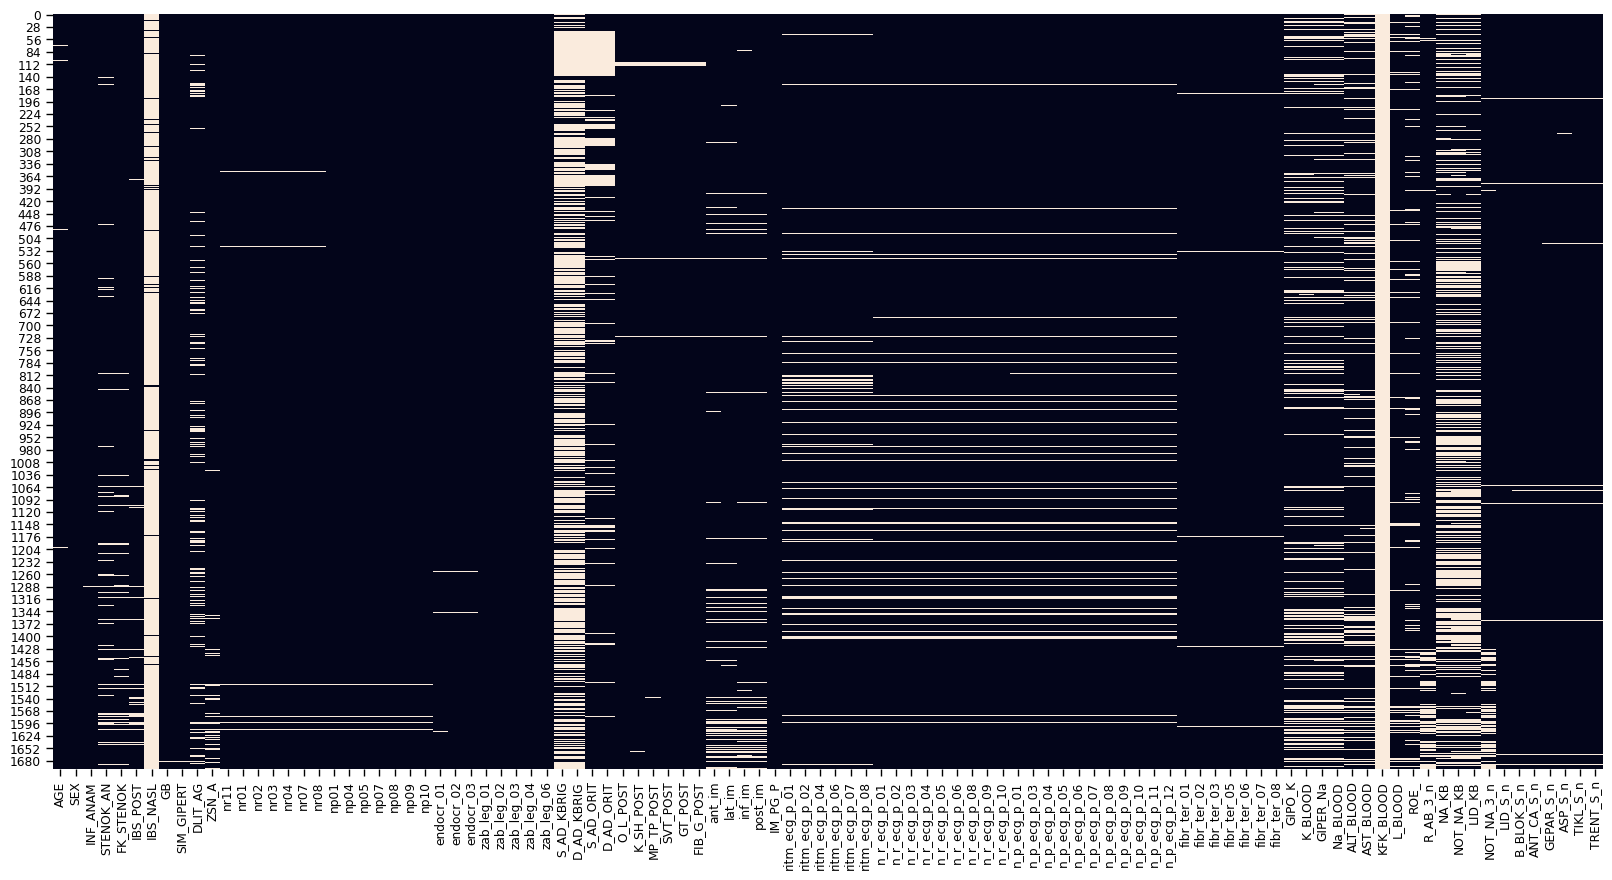

In [81]:
sns.set_context('paper')
plt.figure(figsize = (20,10), dpi = 100)
sns.heatmap(X_total.isnull(), cbar=False);
sns.set_context('poster')

In [82]:
types = np.delete(types, np.array([93, 94, 95, 100, 101, 102, 103, 104, 105]) - 2)

In [83]:
# Drop columns with percentage of nans higher than threshold
threshold = 0.1 # variable from 0 - 1

drop_c = []
types_i = []
for i, c in enumerate(X_total.columns):
    if (X_total[c].isna().sum()) / len(X_total) >= threshold:
        drop_c += [c]
        types_i.append(i)
    
dropped_at_threshold = X_total.drop(drop_c, axis=1)
dropped_balanced = X_balanced.drop(drop_c, axis=1)
df_validation = X_validation.drop(drop_c, axis=1)
types = np.delete(types, types_i)

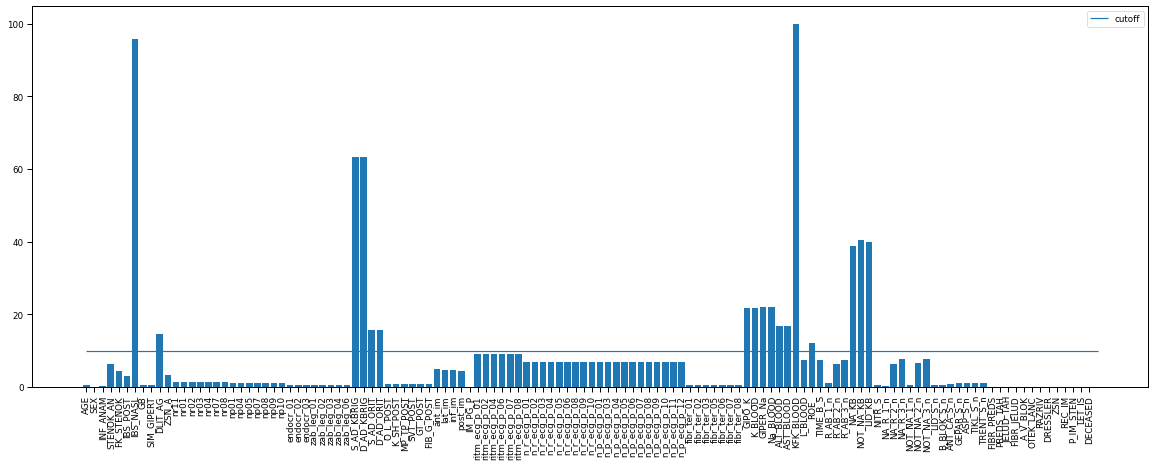

In [84]:
nans = []
sns.set_context('paper')
for column in data.columns:
    a = (sum(data[column].isnull()) / 1700) * 100
    nans += [a]
plt.figure(figsize = (20,7))
plt.bar(list(range(124)),nans)
plt.xticks(list(range(124)), data.columns.values, rotation = 90)
plt.hlines(threshold*100, 0, 124, label = 'cutoff')
plt.legend()
plt.show()
sns.set_context('poster')

In [85]:
dropped_at_threshold.shape

(1700, 85)

In [86]:
# fill remaining nans with mode
dropped_filled_mode = dropped_at_threshold.copy()
dropped_balanced_mode = dropped_balanced.copy()

for c in dropped_filled_mode.columns:
#     dropped_filled_mode[c] = dropped_filled_mode[c].fillna(dropped_filled_mode[c].mode()[0])
#     dropped_balanced_mode[c] = dropped_balanced_mode[c].fillna(dropped_balanced_mode[c].mode()[0])
#     df_validation[c] = df_validation[c].fillna(df_validation[c].mode()[0])
    dropped_filled_mode[c] = dropped_filled_mode[c].fillna(data[c].mode()[0])
    dropped_balanced_mode[c] = dropped_balanced_mode[c].fillna(data[c].mode()[0])
    df_validation[c] = df_validation[c].fillna(data[c].mode()[0])
    # CHECK THIS OUT!!

In [87]:
X_mode = np.array(dropped_filled_mode)
X_mode_balanced = np.array(dropped_balanced_mode)
X_validation = np.array(df_validation)

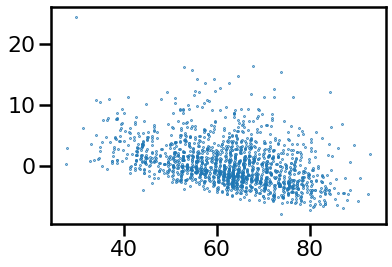

In [88]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3)
# prepare transform on dataset
svd.fit(X_mode)
transformed_X = svd.transform(X_mode)

plt.scatter(transformed_X[:,0], transformed_X[:,1], s=0.5)

In [89]:
transformed_X.shape

(1700, 3)

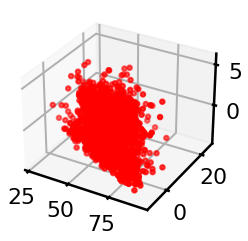

In [90]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed_X[:,0], transformed_X[:,1],transformed_X[:,2], c='r', marker='o')

plt.show()

# Tree based methods

## Decision tree classifier



In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

In [92]:
X = np.array(dropped_filled_mode)
y = data['DECEASED'].ravel()

In [93]:
try:
    filename = 'decisiontree_model.sav'
    decisiontree_model = pickle.load(open(filename, 'rb'))
except: 
    dtree = DecisionTreeClassifier(random_state=0) # Make classifier
    ccp_alphas = np.linspace(0, 1, 50)
    param_grid = {
        'ccp_alpha': ccp_alphas,
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': range(1,11)    
    }
    # CV to find best parameters
    cv_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

    # Fit the grid search model
    cv_grid.fit(X, y)
    filename = 'decisiontree_model.sav'
    pickle.dump(cv_grid.best_estimator_, open(filename, 'wb'))

In [94]:
def true_percentage(y_true, y_pred):
    y_pred_trues = y_pred[y_true == 1]
    percentage = y_pred_trues.sum() / len(y_pred_trues)
    if np.isnan(percentage):
        return 0 
    else: 
        return percentage

In [95]:
K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
decisiontree = decisiontree_model
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    decisiontree.fit(X_train, y_train)
    
    y_pred = decisiontree.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

Overall accuracy: 0.864
Of cases where the response variable of y_true is true, the accuracy is: 0.171


## Bagging Classifier

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [97]:
# X = np.array(dropped_filled_mode)
# y = data['DECEASED'].ravel()

X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

try:
    filename = 'bagging_classifier.sav'
    bagging_classifier = pickle.load(open(filename, 'rb'))
except:
    bagging = BaggingClassifier(DecisionTreeClassifier(), bootstrap=True, oob_score = True)
    param_grid = {
        'n_estimators': range(1,150),    
    }

    bagging_grid = GridSearchCV(estimator = bagging, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

    # Fit the grid search model
    bagging_grid.fit(X, y)
    bagging_classifier = bagging_grid.best_estimator_
    filename = 'bagging_classifier.sav'
    pickle.dump(bagging_classifier, open(filename, 'wb'))

In [98]:
# X = np.array(dropped_filled_mode)
# y = data['DECEASED'].ravel()
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    bagging_classifier.fit(X_train, y_train)
    
    y_pred = bagging_classifier.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

print('VALIDATION')
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()
X_validation = np.array(df_validation)

# Standardize X_train and X_test (based on X_train)

# combine data again
bagging_classifier.fit(X,y)
y_pred = bagging_classifier.predict(X_validation)
print('Overall accuracy:',accuracy_score(y_validation, y_pred))
print('True accuracy:',true_percentage(y_validation, y_pred))

Overall accuracy: 0.962
Of cases where the response variable of y_true is true, the accuracy is: 0.993
VALIDATION
Overall accuracy: 0.8647058823529412
True accuracy: 0.38461538461538464


## Random forest classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [99]:
try:
    filename = 'rf_classifier.sav'
    rf_classifier = pickle.load(open(filename, 'rb'))
except:
    rfc = RandomForestClassifier(bootstrap=True, oob_score=True, criterion = 'gini',random_state=0)
    # number of trees
    n_estimators = range(5,101)
    max_depth = range(1,11)
    max_features = range(10,250,20)

    # Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth
    }

    rf_grid = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

    # Fit the grid search model
    rf_grid.fit(X, y)
    rf_classifier = rf_grid.best_estimator_
    filename = 'rf_classifier.sav'
    pickle.dump(rf_classifier, open(filename, 'wb'))

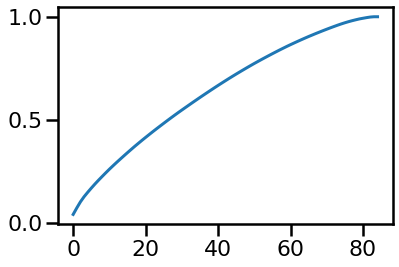

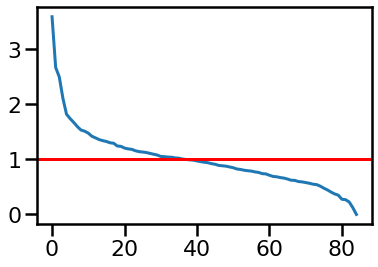

In [100]:
X = np.array(dropped_filled_mode)
y = data['DECEASED'].ravel()

# Standardize the data


X = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA()
pc = pca.fit_transform(X)

eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

plt.plot(eigenvalues)
plt.axhline(y=1, c='r');

In [101]:
# X = np.array(dropped_filled_mode)
# y = data['DECEASED'].ravel()
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

# X = pc[:, :7] # PCA

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    rf_classifier.fit(X_train, y_train)
    
    y_pred = rf_classifier.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

print('VALIDATION')
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()
X_validation = np.array(df_validation)

# combine data again
rf_classifier.fit(X,y)
y_pred = rf_classifier.predict(X_validation)
print('Overall accuracy:',accuracy_score(y_validation, y_pred))
print('True accuracy:',true_percentage(y_validation, y_pred))

Overall accuracy: 0.872
Of cases where the response variable of y_true is true, the accuracy is: 0.890
VALIDATION
Overall accuracy: 0.8382352941176471
True accuracy: 0.5576923076923077


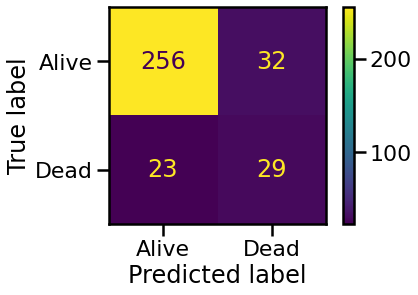

In [102]:
cm = confusion_matrix(y_validation, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive','Dead'])
disp.plot();

## AdaBoost

An AdaBoost [1] classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [103]:
# Try to experiment with max_samples, max_features, number of modles, and other models
try:
    filename = 'adaboost_classifier.sav'
    adaboost_classifier = pickle.load(open(filename, 'rb'))
except:
    n_estimators = range(5,101)
    max_depth = range(1,11)
    learning_rate = np.linspace(1,2,5)
    boosts = []
    #We do an outer loop over max_depth here ourselves because we cannot include in the CV paramgrid.
    #Notice this is not a "proper" way to select the best max_depth but for the purpose of vizuallizing behaviour it should do
    test_acc = np.zeros((len(n_estimators), len(max_depth)))
    for j, i in enumerate(max_depth):
        # Create and fit an AdaBoosted decision tree
        boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 learning_rate=1.0)

        param_grid = {
            'n_estimators': n_estimators
        }
        boost_grid = GridSearchCV(estimator = boost, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

        # Fit the grid search model
        boost_grid.fit(X, y)

        test_acc[:,j] = boost_grid.cv_results_['mean_test_score']
        boosts.append(boost_grid)
    adaboost_classifier = boosts[np.argmax(test_acc.mean(axis=0))].best_estimator_
    filename = 'adaboost_classifier.sav'
    pickle.dump(adaboost_classifier, open(filename, 'wb'))

In [104]:
# fig, ax = plt.subplots(figsize=(15,15))
# ax.plot(n_estimators, test_acc)
# ax.set_xlabel('Maximum tree depth')
# ax.set_ylabel('Mean test accuracy')
# ax.legend(['MaxDepth=3','MaxDepth=4','MaxDepth=5','MaxDepth=6','MaxDepth=7','MaxDepth=8','MaxDepth=9','MaxDepth=10'])

In [105]:
X = np.array(dropped_filled_mode)
y = data['DECEASED'].ravel()

K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

X = pc[:,:10]

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    adaboost_classifier.fit(X_train, y_train)
    
    y_pred = adaboost_classifier.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

print('VALIDATION')
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()
X_validation = np.array(df_validation)

# combine data again
adaboost_classifier.fit(X,y)
y_pred = adaboost_classifier.predict(X_validation)
print('Overall accuracy:',accuracy_score(y_validation, y_pred))
print('True accuracy:',true_percentage(y_validation, y_pred))

Overall accuracy: 0.861
Of cases where the response variable of y_true is true, the accuracy is: 0.262
VALIDATION
Overall accuracy: 0.8558823529411764
True accuracy: 0.1346153846153846


## Logistic Regression

In [106]:
from sklearn.linear_model import LogisticRegression

X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

try:
    filename = 'logistic_model2.sav'
    logistic_model = pickle.load(open(filename, 'rb'))
except:
    logistic_model = LogisticRegression(random_state = 42)
    # number of trees
    penalty = ['l1', 'l2', 'elasticnet']
    solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    class_weight = [None, 'balanced',{0:0.4,1:0.6},{0:0.5,1:0.5},{0:0.6,1:0.4},{0:0.7,1:0.3},{0:0.3,1:0.7}]
    class_weight = [None, 'balanced']

    # Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
    param_grid = {
        'penalty': penalty,
        'solver': solver,
        'class_weight': class_weight
    }

    logistic_grid = GridSearchCV(estimator = logistic_model, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

    # Fit the grid search model
    logistic_grid.fit(X, y)
    logistic_model = logistic_grid.best_estimator_
    filename = 'logistic_model.sav'
    pickle.dump(logistic_model, open(filename, 'wb'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [107]:
logistic_model

LogisticRegression(random_state=42, solver='liblinear')

Overall accuracy: 0.781
Of cases where the response variable of y_true is true, the accuracy is: 0.768
VALIDATION
Overall accuracy: 0.7705882352941177
True accuracy: 0.6153846153846154


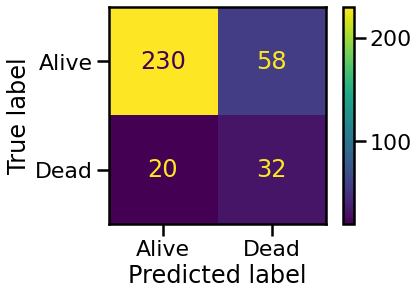

In [108]:
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

def centerData(data):
    mu = np.mean(data,axis=0)
    data = data - mu
    return data, mu

K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []
# logistic_model = LogisticRegression(random_state = 42)
for i, (train_index, test_index) in enumerate(kf.split(X)):
     # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    X_train_con = X_train[:, np.argwhere(types == 'Real').ravel()]
    X_test_con = X_test[:, np.argwhere(types == 'Real').ravel()]

    X_train_cat = X_train[:,np.argwhere(types != 'Real').ravel()]
    X_test_cat = X_test[:,np.argwhere(types != 'Real').ravel()]

    # Standardize X_train and X_test (based on X_train)
    scaler = StandardScaler()
    scaler.fit(X_train_con)
    X_train_con = scaler.transform(X_train_con)
    X_test_con = scaler.transform(X_test_con)


    # combine data again
    X_train = np.concatenate((X_train_con, X_train_cat), axis=1)
    X_test = np.concatenate((X_test_con, X_test_cat), axis = 1)
    
    logistic_model.fit(X_train, y_train)
    
    y_pred = logistic_model.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]
    
test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")  

# Validation
print('VALIDATION')
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()
X_validation = np.array(df_validation)

# Standardize X_train and X_test (based on X_train)
scaler.fit(X[:, np.argwhere(types == 'Real').ravel()])
X_validation[:, np.argwhere(types == 'Real').ravel()] = scaler.transform(X_validation[:, np.argwhere(types == 'Real').ravel()])
X[:, np.argwhere(types == 'Real').ravel()] = scaler.transform(X[:, np.argwhere(types == 'Real').ravel()])

# combine data again
logistic_model.fit(X,y)
y_pred = logistic_model.predict(X_validation)
print('Overall accuracy:',accuracy_score(y_validation, y_pred))
print('True accuracy:',true_percentage(y_validation, y_pred))

cm = confusion_matrix(y_validation, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive','Dead'])
disp.plot();

## Support Vector Machine

In [109]:
from sklearn.svm import SVC

X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

try:
    filename = 'SVC.sav'
    svc = pickle.load(open(filename, 'rb'))
except:
    svc = SVC(random_state = 42)
    C = np.linspace(1,15,50)
    degree = range(1,2)
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']

    # Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
    param_grid = {
        'C': C,
        'kernel': kernel,
        'degree': degree
    }

    svc_grid = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

    # Fit the grid search model
    svc_grid.fit(X, y)
    svc = svc_grid.best_estimator_
    filename = 'SVC.sav'
    pickle.dump(svc, open(filename, 'wb'))

In [110]:
svc

SVC(C=11.285714285714285, degree=1, kernel='linear', random_state=42)

In [111]:
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()

K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []
# logistic_model = LogisticRegression(random_state = 42)
for i, (train_index, test_index) in enumerate(kf.split(X)):
     # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    X_train_con = X_train[:, np.argwhere(types == 'Real').ravel()]
    X_test_con = X_test[:, np.argwhere(types == 'Real').ravel()]

    X_train_cat = X_train[:,np.argwhere(types != 'Real').ravel()]
    X_test_cat = X_test[:,np.argwhere(types != 'Real').ravel()]

    # Standardize X_train and X_test (based on X_train)
    scaler = StandardScaler()
    scaler.fit(X_train_con)
    X_train_con = scaler.transform(X_train_con)
    X_test_con = scaler.transform(X_test_con)


    # combine data again
    X_train = np.concatenate((X_train_con, X_train_cat), axis=1)
    X_test = np.concatenate((X_test_con, X_test_cat), axis = 1)
    
    svc.fit(X_train, y_train)
    
    y_pred = svc.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]
    
test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")   

# Validation
print('VALIDATION')
X = np.array(dropped_balanced_mode)
y = balanced_df['DECEASED'].ravel()
X_validation = np.array(df_validation)

# Standardize X_train and X_test (based on X_train)
scaler.fit(X[:, np.argwhere(types == 'Real').ravel()])
X_validation[:, np.argwhere(types == 'Real').ravel()] = scaler.transform(X_validation[:, np.argwhere(types == 'Real').ravel()])
X[:, np.argwhere(types == 'Real').ravel()] = scaler.transform(X[:, np.argwhere(types == 'Real').ravel()])

# combine data again
svc.fit(X,y)
y_pred = svc.predict(X_validation)
print('Overall accuracy:',accuracy_score(y_validation, y_pred))
print('True accuracy:',true_percentage(y_validation, y_pred))

Overall accuracy: 0.800
Of cases where the response variable of y_true is true, the accuracy is: 0.815
VALIDATION
Overall accuracy: 0.7676470588235295
True accuracy: 0.5961538461538461


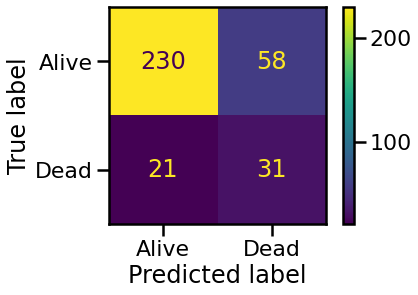

In [112]:
cm = confusion_matrix(y_validation, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive','Dead'])
disp.plot();